In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FuncFormatter


def process_clonotypes_with_umi(folder_path, output_file, umi_threshold=10):
    """
    Process clonotype data from multiple TSV files in a folder, 
    filter by uniqueMoleculeCount, and save the results to an output CSV file.

    Parameters:
    - folder_path: Path to the folder containing TSV files.
    - output_file: Path to the output CSV file.
    - umi_threshold: The minimum value of 'uniqueMoleculeCount' to filter clonotypes (default is 10).
    """
    # List to hold all clonotype data with filename, count, and TotalUMI
    all_clonotype_data = []

    # Traverse through all files in the folder and subfolders
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".tsv"):  # Process only .tsv files
                file_path = os.path.join(root, filename)
                print(f"Processing file: {file_path}")

                # Load the TSV file
                data = pd.read_csv(file_path, sep='\t')

                # Check if required columns exist
                if 'aaSeqCDR3' in data.columns and 'uniqueMoleculeCount' in data.columns:
                    # Drop rows with missing values in the required columns
                    filtered_data = data[['aaSeqCDR3', 'uniqueMoleculeCount']].dropna()

                    # Filter by uniqueMoleculeCount threshold
                    filtered_data = filtered_data[filtered_data['uniqueMoleculeCount'] >= umi_threshold]

                    # Group by Clonotype (aaSeqCDR3) and calculate Count and TotalUMI
                    grouped = filtered_data.groupby('aaSeqCDR3').agg(
                        Count=('aaSeqCDR3', 'size'),
                        TotalUMI=('uniqueMoleculeCount', 'sum')
                    ).reset_index()

                    # Add the filename column
                    grouped['Filename'] = filename

                    # Append to the overall data list
                    all_clonotype_data.append(grouped)
                else:
                    print(f"Warning: Required columns ('aaSeqCDR3', 'uniqueMoleculeCount') not found in {filename}")

    # Concatenate all results into a single DataFrame
    if all_clonotype_data:
        result_df = pd.concat(all_clonotype_data, ignore_index=True)
        result_df.rename(columns={'aaSeqCDR3': 'Clonotype'}, inplace=True)

        # Reorder columns for clarity
        result_df = result_df[['Filename', 'Clonotype', 'Count', 'TotalUMI']]

        # Save the result to a CSV file
        result_df.to_csv(output_file, index=False)
        print(f"Clonotype data saved to {output_file}")

    return result_df if all_clonotype_data else None


def plot_total_umi_distribution(file_path, output_png):
    """
    This function reads a CSV file containing clonotype data and generates a line plot
    for the total UMI distribution based on experiment patterns (Exp2/Exp3).
    
    Parameters:
    file_path (str): Path to the CSV file containing the data.
    """
    # Load the CSV file
    data = pd.read_csv(file_path)

    # Check for experiment type based on filenames
    unique_filenames = data['Filename'].unique()

    # Define the patterns based on the filenames
    if any("IMGT" in fn for fn in unique_filenames):
        patterns = ["MME", "D2", "PBMC"]
    elif any("Exp3" in fn for fn in unique_filenames):
        patterns = ["MMC", "D2", "PBMC"]
    else:
        # Default pattern if neither Exp2 nor Exp3 is found
        patterns = ["MMC", "D2",  "PBMC"]

    # Create subplots: 1 row, one column per pattern
    nrows = 1
    ncols = len(patterns)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3))

    # If only one row, axes is a 1D array
    # We will plot multiple lines (files) in each relevant axis (column)

    # Group data by 'Filename'
    grouped = data.groupby('Filename')

    # Custom formatter for y-axis (in thousands)
    # formatter = FuncFormatter(lambda y, _: f"${y/(1e3):.0f}$" if y > 0 else "0") ##--dividing by 1000 to have the scale in thousands
    formatter = FuncFormatter(lambda y, _: f"${y/(1):.0f}$" if y > 0 else "0")

    # For each file, determine which pattern it belongs to and plot in the appropriate column
    for filename, group in grouped:
        # Identify which pattern this filename corresponds to
        matched_pattern = None
        for p in patterns:
            if p in filename:
                matched_pattern = p
                break
        
        # If no pattern found by direct substring match, skip
        if matched_pattern is None:
            continue

        # Sort data by 'TotalUMI' in descending order
        sorted_group = group.sort_values(by='TotalUMI', ascending=False).reset_index(drop=True)
        
        # Create a line plot with indexes on the x-axis and 'TotalUMI' on the y-axis
        x_values = sorted_group.index
        y_values = sorted_group['TotalUMI']
        
        # Determine the axis based on the matched pattern
        col_index = patterns.index(matched_pattern)
        ax = axes[col_index]

        # Plot the line and fill the area under the curve
        ax.plot(x_values, y_values, color='steelblue', linewidth=2, alpha=0.8, label=filename)
        ax.fill_between(x_values, y_values, color='lightblue', alpha=0.2)
        
        # Use a logarithmic scale for x if desired
        ax.set_xscale('log')
        ax.yaxis.set_major_formatter(formatter)
        # ax.set_ylim(0,1e6)
        
        # Set labels and formatting
        if not ax.get_title():
            ax.set_title(f"{matched_pattern}", fontsize=14)
        # ax.set_ylabel('Total unique UMI\n(thousands)', fontsize=12)
        ax.set_ylabel('Total unique UMI', fontsize=12)
        ax.tick_params(axis='x', rotation=45)

    # Add an overarching title and adjust layout
    # plt.suptitle("TotalUMI Distributions by Dilution", fontsize=16, y=1.05)
    # Add a super bottom title/caption at the bottom center of the figure
    fig.text(
        0.5,       # x-position (center)
        0.01,      # y-position (close to the bottom)
        "Clonotype Count",  # your text
        ha='center',  # horizontal alignment
        fontsize=12
    )
    
    
    plt.tight_layout()

    # Save the figure
    plt.savefig(output_png, dpi=300)

    plt.show()

# Example usage:
# plot_total_umi_distribution('/home/rittika/Workprojects/iRepertoire/clonotypes_with_filenames_and_umi.csv')

def calculate_and_plot_sums(data, output_png, marker_color='steelblue'):
    """
    Calculate the sum of 'Count' and 'TotalUMI' per 'Filename' and create a scatter plot
    where each filename is on the x-axis as a category, the y-axis shows total clonotypes,
    and the marker size encodes total UMI, with a specific sorting pattern.
    """

    import matplotlib.pyplot as plt
    import numpy as np

    # Determine the unique filenames
    unique_filenames = data['Filename'].unique()

    # Define the patterns based on the filenames
    if any("RNA" in fn for fn in unique_filenames):
        patterns = ["MME", "D2", "PBMC"]
    elif any("Exp3" in fn for fn in unique_filenames):
        patterns = ["MMC", "D2", "PBMC"]
    else:
        # Default pattern if neither Exp2 nor Exp3 is found
        patterns = ["MMC", "D2",  "PBMC"]

    # Group by Filename and calculate the sums
    sums = data.groupby('Filename')[['Count', 'TotalUMI']].sum().reset_index()

    # Simplify filenames for x-labels
    sums['SimplifiedName'] = sums['Filename'].apply(lambda x: "_".join(x.split("_")[2:5]))

    # Custom sorting function based on the defined patterns
    def custom_sort(simplified_name):
        for i, pattern in enumerate(patterns):
            if pattern in simplified_name:
                return i
        return len(patterns)  # put any unmatched names at the end

    # Sort the dataframe based on the custom sorting function
    sums['SortOrder'] = sums['SimplifiedName'].apply(custom_sort)
    sums = sums.sort_values(['SortOrder', 'Count'], ascending=[True, True]).reset_index(drop=True)

    # Extract x, y, and UMI values
    x_labels = sums['SimplifiedName']
    x = range(len(x_labels))
    y = sums['Count']
    umi = sums['TotalUMI']

    # Create a scatter plot
    plt.figure(figsize=(12, 6))

    # Use the TotalUMI to scale marker sizes. Adjust the scaling factor as needed.
    marker_sizes = (umi / umi.max()) * 500  # scale factor for visibility

    # scatter = plt.scatter(x, y, s=marker_sizes, alpha=0.7, c=umi, cmap='viridis', edgecolor='black')
    scatter = plt.scatter(x, y, s=marker_sizes, alpha=0.7, c=marker_color, edgecolor='black')

    # Set x-ticks to show simplified filenames
    plt.xticks(x, x_labels, rotation=45, ha='right', fontsize=10)

    # Label axes
    plt.xlabel('Filename', fontsize=12)
    plt.ylabel('Total Clonotypes', fontsize=12)
    plt.title('Clonotypes vs. UMI per Dilution', fontsize=14)

    # # Add a colorbar to show UMI mapping
    # cbar = plt.colorbar(scatter)
    # cbar.set_label('Total UMI', fontsize=12)

    plt.tight_layout()

    # Save the plot
    plt.savefig(output_png, dpi=300)
    plt.show()



Processing file: /home/rittika/Workprojects/Longreads-PacBio/Heavy/TakaraBio/TakaraBio_clonotypes_percentage.tsv
Processing file: /home/rittika/Workprojects/Longreads-PacBio/Heavy/TakaraBio/MiXCR_IMGT_MME_TKB_PacBio.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Longreads-PacBio/Heavy/TakaraBio/MiXCR_IMGT_PBMC_TKB_PacBio.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Longreads-PacBio/Heavy/TakaraBio/MiXCR_IMGT_D2_TKB_PacBio.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Longreads-PacBio/Heavy/TakaraBio/TakaraBio_clonotypes_with_filenames_and_umi.tsv
Clonotype data saved to TakaraBio_clonotypes_with_filenames_and_umi.csv


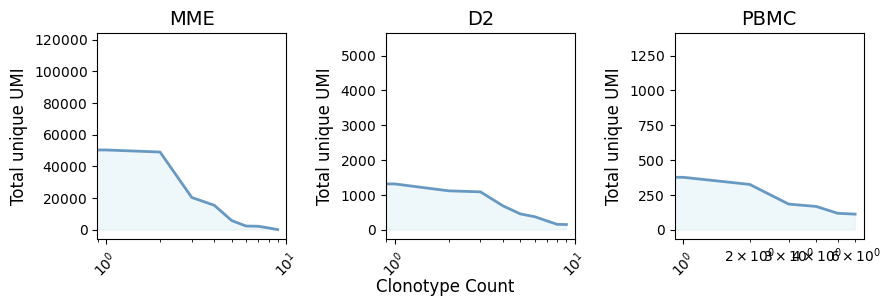

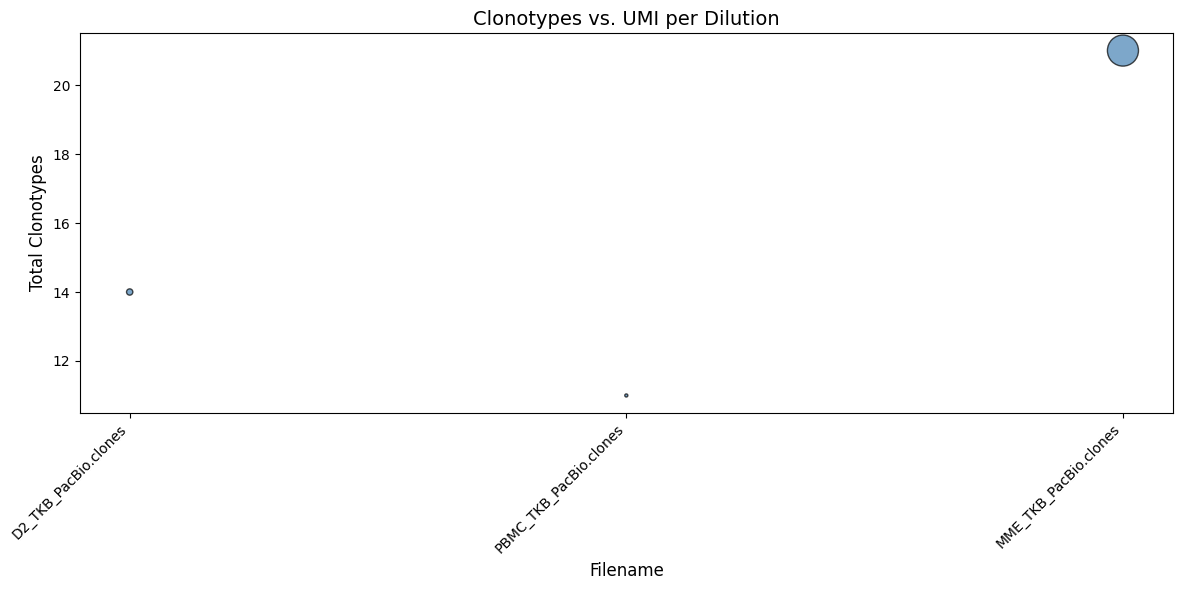

In [2]:

# Define folder path
folder_path = "/home/rittika/Workprojects/Longreads-PacBio/Heavy/TakaraBio"  # Replace with your folder path

# Generate dynamic output file names based on folder path
folder_name = os.path.basename(folder_path.rstrip("/\\"))
output_file = f"{folder_name}_clonotypes_with_filenames_and_umi.csv"
lineplot_output_png = f"{folder_name}_lineplots_threshold100.png"
heatmap_output_png = f"{folder_name}_clonotype_vs_uniqUMI_heatmap.png"

# Call the function
result_df = process_clonotypes_with_umi(folder_path, output_file, umi_threshold=100)
if result_df is not None:
    plot_total_umi_distribution(output_file, lineplot_output_png)
    calculate_and_plot_sums(result_df, heatmap_output_png)
